# Supervised vs Unsupervised vs Semi-supervised — Project Notebook

This notebook includes:
1. Loading the provided CSV datasets.
2. **Supervised** example: SVM (support vectors visualized).
3. **Unsupervised** example: K-Means clustering.
4. **Semi-supervised** example: Label Propagation (partial labels).

Run cells in order. Requirements: `scikit-learn`, `matplotlib`, `pandas`, `numpy`.


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.semi_supervised import LabelPropagation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, adjusted_rand_score

print('Libraries loaded')


Libraries loaded


In [6]:
# Paths to the datasets saved earlier
sup_path = 'supervised_dataset.csv'
unsup_path = 'unsupervised_dataset.csv'
semi_path = 'semi_supervised_dataset.csv'

df_sup = pd.read_csv(sup_path)
df_unsup = pd.read_csv(unsup_path)
df_semi = pd.read_csv(semi_path)

print('Loaded datasets:')
print(' Supervised:', df_sup.shape)
print(' Unsupervised:', df_unsup.shape)
print(' Semi-supervised:', df_semi.shape)


Loaded datasets:
 Supervised: (200, 3)
 Unsupervised: (200, 3)
 Semi-supervised: (300, 3)


## 1) Supervised — SVM (linear)

Train an SVM on the supervised CSV and plot decision surface and support vectors.


Supervised SVM accuracy: 0.967
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.97        30
         1.0       0.94      1.00      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



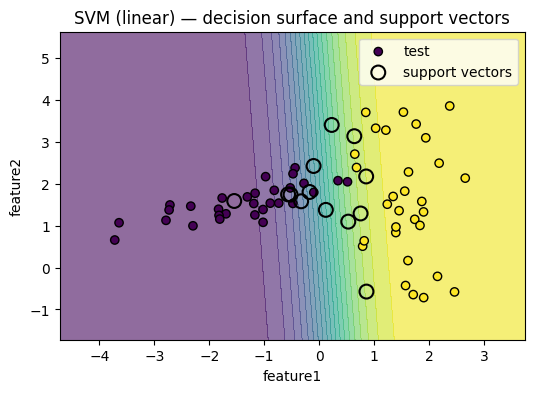

In [7]:
X = df_sup[['feature1','feature2']].values
y = df_sup['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

svm = SVC(kernel='linear', probability=True, random_state=0)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print('Supervised SVM accuracy:', round(accuracy_score(y_test, y_pred), 3))
print(classification_report(y_test, y_pred))

# Plot decision surface and support vectors
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200),
                     np.linspace(X[:,1].min()-1, X[:,1].max()+1, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
probs = svm.predict_proba(grid)[:,1].reshape(xx.shape)

plt.figure(figsize=(6,4))
plt.contourf(xx, yy, probs, levels=20, alpha=0.6)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='o', edgecolor='k', label='test')
# support vectors
sv = svm.support_vectors_
plt.scatter(sv[:,0], sv[:,1], s=100, facecolors='none', edgecolor='k', linewidths=1.5, label='support vectors')
plt.title('SVM (linear) — decision surface and support vectors')
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.legend()
plt.show()


## 2) Unsupervised — K-Means

Run K-Means on the blobs CSV, print ARI, and plot clusters + centers.


Adjusted Rand Index: 1.0


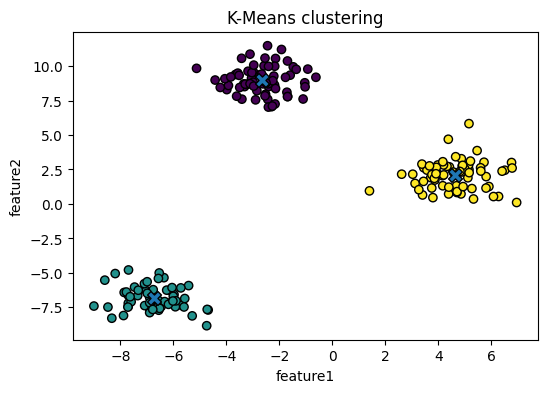

In [15]:
X_u = df_unsup[['feature1','feature2']].values
true = df_unsup['true_cluster'].values

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_u)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

print('Adjusted Rand Index:', round(adjusted_rand_score(true, labels), 3))

plt.figure(figsize=(6,4))
plt.scatter(X_u[:,0], X_u[:,1], c=labels, marker='o', edgecolor='k')
plt.scatter(centers[:,0], centers[:,1], marker='X', s=100, edgecolor='k')
plt.title('K-Means clustering')
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.show()


## 3) Semi-supervised — Label Propagation

Load the moons CSV, hide most labels (only 10% labeled), fit LabelPropagation, and evaluate on a test set.


Training samples: 210, labeled: 21, unlabeled: 189
Semi-supervised accuracy: 0.978
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        45
         1.0       0.98      0.98      0.98        45

    accuracy                           0.98        90
   macro avg       0.98      0.98      0.98        90
weighted avg       0.98      0.98      0.98        90



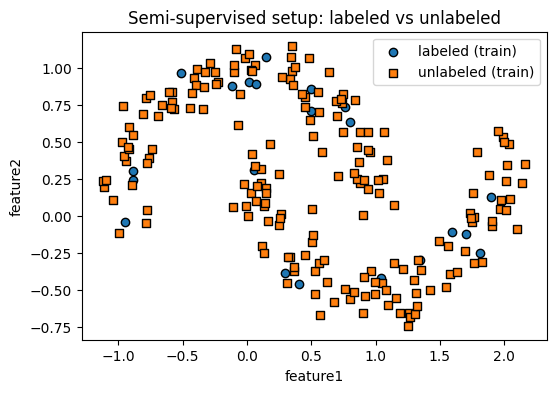

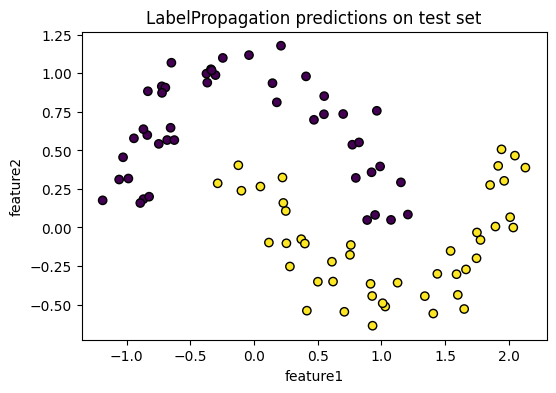

In [9]:
X_s = df_semi[['feature1','feature2']].values
y_s = df_semi['label'].values

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size=0.3, random_state=1, stratify=y_s)

rng = np.random.RandomState(2)
n_total = X_train_s.shape[0]
n_labeled = int(0.1 * n_total)
indices = np.arange(n_total)
rng.shuffle(indices)
labeled_indices = indices[:n_labeled]
unlabeled_indices = indices[n_labeled:]

y_train_partial = np.copy(y_train_s)
y_train_partial[unlabeled_indices] = -1

print(f'Training samples: {n_total}, labeled: {n_labeled}, unlabeled: {n_total - n_labeled}')

label_prop = LabelPropagation()
label_prop.fit(X_train_s, y_train_partial)

y_test_pred = label_prop.predict(X_test_s)
print('Semi-supervised accuracy:', round(accuracy_score(y_test_s, y_test_pred), 3))
print(classification_report(y_test_s, y_test_pred))

plt.figure(figsize=(6,4))
plt.scatter(X_train_s[labeled_indices,0], X_train_s[labeled_indices,1], marker='o', label='labeled (train)', edgecolor='k')
plt.scatter(X_train_s[unlabeled_indices,0], X_train_s[unlabeled_indices,1], marker='s', label='unlabeled (train)', edgecolor='k')
plt.title('Semi-supervised setup: labeled vs unlabeled')
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(X_test_s[:,0], X_test_s[:,1], c=y_test_pred, marker='o', edgecolor='k')
plt.title('LabelPropagation predictions on test set')
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.show()
